In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set()

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pyresample
import numpy as np

print(tf.__version__)

2.0.0


In [2]:
train_file_path = 'train.csv'
test_file_path = 'test.csv'

column_names = ['date', 'in_out', 'latitude', 'longitude',
                '6~7_ride', '7~8_ride', '8~9_ride',
                '9~10_ride', '10~11_ride', '11~12_ride',
                '6~7_takeoff', '7~8_takeoff', '8~9_takeoff',
                '9~10_takeoff', '10~11_takeoff', '18~20_ride']
column_names_test = ['date', 'in_out', 'latitude', 'longitude',
                '6~7_ride', '7~8_ride', '8~9_ride',
                '9~10_ride', '10~11_ride', '11~12_ride',
                '6~7_takeoff', '7~8_takeoff', '8~9_takeoff',
                '9~10_takeoff', '10~11_takeoff']

train_raw = pd.read_csv(train_file_path, usecols=column_names,
                        na_values='?', skipinitialspace=True)
test_raw = pd.read_csv(test_file_path, usecols=column_names_test,
                       na_values='?', skipinitialspace=True)

In [3]:
train_raw.tail()

,date,in_out,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,18~20_ride
415418,2019-09-30,시내,33.41437,126.26336,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415419,2019-09-30,시내,33.49946,126.51479,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415420,2019-09-30,시내,33.23100,126.26273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
415421,2019-09-30,시내,33.46483,126.31870,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415422,2019-09-30,시내,33.24873,126.50799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0


In [4]:
LON = np.linspace(train_raw['longitude'].min(), train_raw['longitude'].max(), 50)
LAT = np.linspace(train_raw['latitude'].min(), train_raw['latitude'].max(), 50)

# 제일 거리가 가까운 grid 인덱스 찾기
def geo_idx(dd, dd_array):
    geo_idx = (np.abs(dd_array - dd)).argmin()
    return geo_idx

def make_dataset(df):
    dataset = df.copy()
    dataset['date'] = pd.to_datetime(dataset['date'])
    dataset['weekday'] = dataset['date'].dt.weekday
    
    # 주말 데이터
    dataset['weekend'] = (dataset['weekday'] >= 5).astype(float)
    
    # 휴일 데이터
    holidays = pd.to_datetime(['2019-09-12', '2019-09-13', '2019-09-14', 
                           '2019-10-03', '2019-10-09'])
    dataset['holidays'] = dataset['date'].isin(holidays)*1.0
    
    # 요일 one hot encoding
    dataset['mon'] = (dataset['weekday'] == 0)*1.0
    dataset['tue'] = (dataset['weekday'] == 1)*1.0
    dataset['wed'] = (dataset['weekday'] == 2)*1.0
    dataset['thu'] = (dataset['weekday'] == 3)*1.0
    dataset['fri'] = (dataset['weekday'] == 4)*1.0
    dataset['sat'] = (dataset['weekday'] == 5)*1.0
    dataset['sun'] = (dataset['weekday'] == 6)*1.0
    
    # 필요 없는 칼럼 지우기
    dataset.drop(['date', 'weekday'], 1, inplace=True)
    
    in_out = dataset.pop('in_out')
    dataset['in'] = (in_out == '시내')*1.0
    dataset['out'] = (in_out == '시외')*1.0
    
    dataset['grid_lon'] = dataset['longitude'].map(lambda x: geo_idx(x, LON))
    dataset['grid_lat'] = dataset['latitude'].map(lambda x: geo_idx(x, LAT))
    
    dataset = pd.get_dummies(dataset, columns=['grid_lon', 'grid_lat'])
    dataset.drop(['latitude', 'longitude'], 1, inplace=True)
    
    return dataset

In [5]:
train_dataset = make_dataset(train_raw)
train_labels = train_dataset.pop('18~20_ride')
test_dataset = make_dataset(test_raw)
train_dataset.tail()

,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,...,grid_lat_17,grid_lat_18,grid_lat_19,grid_lat_20,grid_lat_21,grid_lat_22,grid_lat_23,grid_lat_47,grid_lat_48,grid_lat_49
415418,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
415419,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
415420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
415421,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
415422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
set(train_dataset.columns) - set(test_dataset.columns)

{'grid_lat_47'}

In [7]:
test_dataset['grid_lat_47'] = 0

In [8]:
test_dataset.tail()

,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,...,grid_lat_17,grid_lat_18,grid_lat_19,grid_lat_20,grid_lat_21,grid_lat_22,grid_lat_23,grid_lat_48,grid_lat_49,grid_lat_47
228165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
228166,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
228167,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
228168,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
228169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
numeric_columns = [
    '6~7_ride', '7~8_ride', '8~9_ride',
    '9~10_ride', '10~11_ride', '11~12_ride',
    '6~7_takeoff', '7~8_takeoff', '8~9_takeoff',
    '9~10_takeoff', '10~11_takeoff'
]

categorical_columns = train_dataset.columns.difference(numeric_columns)

train_stats = train_dataset.describe()
train_stats.drop(categorical_columns, 1, inplace=True)
train_stats = train_stats.T
train_stats

,count,mean,std,min,25%,50%,75%,max
6~7_ride,415423.0,0.305893,1.109766,0.0,0.0,0.0,0.0,85.0
7~8_ride,415423.0,0.829699,2.255116,0.0,0.0,0.0,1.0,94.0
8~9_ride,415423.0,0.815350,2.317561,0.0,0.0,0.0,1.0,136.0
9~10_ride,415423.0,0.642475,1.959844,0.0,0.0,0.0,1.0,78.0
10~11_ride,415423.0,0.599618,1.885941,0.0,0.0,0.0,0.0,124.0
11~12_ride,415423.0,0.579393,1.942137,0.0,0.0,0.0,0.0,99.0
6~7_takeoff,415423.0,0.112870,0.597714,0.0,0.0,0.0,0.0,45.0
7~8_takeoff,415423.0,0.344870,1.279179,0.0,0.0,0.0,0.0,66.0
8~9_takeoff,415423.0,0.516481,1.658850,0.0,0.0,0.0,0.0,59.0
9~10_takeoff,415423.0,0.430922,1.485124,0.0,0.0,0.0,0.0,65.0


In [10]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset[numeric_columns])
normed_train_data[categorical_columns] = train_dataset[categorical_columns]
normed_test_data = norm(test_dataset[numeric_columns])
normed_test_data[categorical_columns] = test_dataset[categorical_columns]

In [11]:
normed_train_data.tail()

,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,...,holidays,in,mon,out,sat,sun,thu,tue,wed,weekend
415418,3.328726,-0.367918,-0.351814,-0.32782,-0.317941,-0.298327,-0.188837,-0.269603,-0.311349,-0.290159,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415419,3.328726,-0.367918,-0.351814,-0.32782,-0.317941,-0.298327,-0.188837,-0.269603,-0.311349,-0.290159,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415420,-0.275637,-0.367918,-0.351814,-0.32782,-0.317941,-0.298327,-0.188837,0.512149,-0.311349,-0.290159,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415421,0.625453,-0.367918,-0.351814,-0.32782,-0.317941,-0.298327,-0.188837,-0.269603,-0.311349,-0.290159,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415422,-0.275637,-0.367918,-0.351814,-0.32782,-0.317941,-0.298327,-0.188837,-0.269603,2.099961,-0.290159,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
])

model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mae', 'mse']
)

In [13]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


In [14]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')


.............

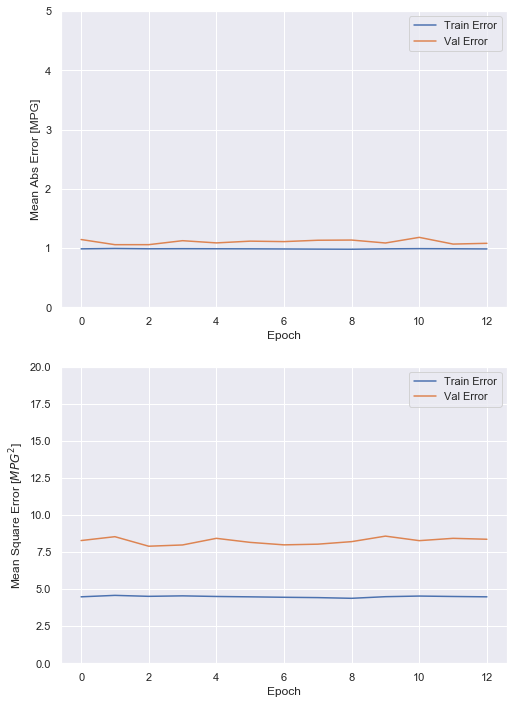

In [21]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

EPOCHS = 1000
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, batch_size=1000,
                    validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [22]:
predictions = model.predict(normed_test_data)

In [17]:
submission_path = 'submission_sample.csv'
submission = pd.read_csv(submission_path)
submission['18~20_ride'] = predictions
submission.to_csv("submission.csv", index=False)

In [18]:
submission.tail()

,id,18~20_ride
228165,643588,-0.066586
228166,643589,-0.052186
228167,643590,0.788714
228168,643591,1.110822
228169,643592,-0.047335
